# Time Series Forecast: Features &rarr; Emissions (monthly resolution)

### To evaluate:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 
- Make decision on 'look_back' and 'horizon'

### Import libraries

In [33]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from scipy.ndimage import shift

### Some useful functions

In [34]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [35]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title = plttitle)
    ax.set(ylabel = metric[0].swapcase() + metric[1:])
    ax.set(xlabel = 'Epoch')
    ax.legend(['train', 'val'], loc = 'upper right')

### Read in input data (features) - X

In [36]:
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        continue
        #print(f"Feature not used: {i}")
        
date_first = feature_data.index[0]
date_last = feature_data.index[-1]
first_date = date_first.strftime("%m/%Y")
last_date = date_last.strftime("%m/%Y")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input data (samples, features): {feature_data.shape}")
print(f"Input data starts at: {first_date} and ends at: {last_date}")

Shape input data (samples, features): (111, 40)
Input data starts at: 01/2011 and ends at: 03/2020


### Read in target data (emissions) - y

In [37]:
emission_data = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')

# Take only the emissions on which we have indicators
emission_data = emission_data[21*12:31*12-9] # from: 01/2011 - until: 03/2020
print(f"Shape output data (samples, emission): {emission_data.shape}")

Shape output data (samples, emission): (111,)


### Data preparation

In [38]:
def prepare_data(input_data, output_data, look_back=1, horizon=1, shuffle=False, apply_pca=False, pca_comp=10, scaler = None):
    
    dataX, dataY = [], []
    
    # Check data requirements
    if len(input_data) != len(output_data):
        raise ValueError('Input and ouput do not have same length!')
    
    # Apply PCA to data
    if apply_pca:
        pca = PCA(n_components = pca_comp)
        input_data = pca.fit_transform(input_data)
        print(f"PCA applied on feature input data - New feature input shape: {input_data.shape}")
        
    # Apply data scaler
    if scaler == None:
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'Standard':
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'MinMax':
        scaler = MinMaxScaler()
        input_data = scaler.fit_transform(input_data)
    else:
        raise ValueError('scaler variable has to be either \'Standard\' or \'MinMax\'!')           
    
    # Apply 'windowing' to data
    #for i in range(len(input_data)-look_back-horizon):
        #dataX.append(input_data[i:(i+look_back)])
        #dataY.append(output_data[(i+look_back):(i+look_back+horizon)])
    for i in range(len(input_data)-look_back+1):
        dataX.append(input_data[i:(i+look_back), :])
        dataY.append(emission_data[i+look_back:i+look_back+horizon])
    
    # Shuffle data
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
        
    return np.array(dataX), np.array(dataY)

### Define dataset properties

In [39]:
look_back = 12        # months to look back (input data)
horizon = 6           # months to look ahead (target data)
split_ratio = 0.75    # split ratio training / testing 
shuffle = True        # shuffle data yes / no
pca = False           # apply PCA to input data yes / no
scaler = 'Standard'   # choose data scaling method ...
                      # ... either 'Standard' or 'MinMax'

    
# Split into train and test sets according to split_ratio
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back + horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Define different neural network architectures

### Multi Layer Perceptron - MLP (vanilla)

In [40]:
def create_mlp(look_back, horizon, plot_summary = False):
    
    model = Sequential(name='MLP')
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Flatten(name='MLP_flatten'))
    model.add(Dense(256, activation='elu', name='Dense_1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='elu', name='Dense_2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='elu', name='Dense_3'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='elu', name='Dense_4'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(horizon, activation='linear', name="MLP_final"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model             

### 1D Convolutional Neural Network - CNN (vanilla)

In [41]:
def create_cnn1D(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model

### WaveNet (CNN like Neural Network Architecture) 
Reference: https://arxiv.org/pdf/1703.04691.pdf


In [42]:
def create_wavenet(look_back, horizon, plot_summary = False):   
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, X_train.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out, name='WaveNet')
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model 

### Long Short-Term Memory - LSTM

In [43]:
def create_lstm(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()       

    return model

### Create training and test set

In [44]:
X_train, y_train = prepare_data(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)

print("Shape of training data:")
print(f'Training data - X: {X_train.shape}')
print(f'Training data - y: {y_train.shape}')

Shape of training data:
Training data - X: (72, 12, 40)
Training data - y: (72, 6)


In [45]:
X_test, y_test = prepare_data(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

print("Shape of test data:")
print(f'Test data - X: {X_test.shape}')
print(f'Test data - y: {y_test.shape}')

Shape of test data:
Test data - X: (17, 12, 40)
Test data - y: (17, 6)


### Create an instance of every neural network architecture

In [46]:
wavenet = create_wavenet(look_back, horizon, plot_summary=False)
cnn1D = create_cnn1D(look_back, horizon, plot_summary=False)
lstm = create_lstm(look_back, horizon, plot_summary=False)
mlp = create_mlp(look_back, horizon, plot_summary=False)

### Train model of every instance and show train history

In [47]:
# define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=999, restore_best_weights=True)

# train models
history_wavenet = wavenet.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, verbose=1, callbacks=[es])
history_cnn1D = cnn1D.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, verbose=1, callbacks=[es])
history_lstm = lstm.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, verbose=1, callbacks=[es])
history_mlp = mlp.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, verbose=1, callbacks=[es])


Train on 57 samples, validate on 15 samples
Epoch 1/200
57/57 [==============================] - 4s 63ms/step - loss: 4717.3961 - r2_keras: -217.4889 - val_loss: 4638.2077 - val_r2_keras: -233.9679
Epoch 2/200
57/57 [==============================] - 0s 4ms/step - loss: 4423.1652 - r2_keras: -253.2003 - val_loss: 4231.3953 - val_r2_keras: -213.4517
Epoch 3/200
57/57 [==============================] - 0s 4ms/step - loss: 3739.3117 - r2_keras: -148.1953 - val_loss: 3316.4775 - val_r2_keras: -167.2272
Epoch 4/200
57/57 [==============================] - 0s 4ms/step - loss: 2616.8104 - r2_keras: -135.0997 - val_loss: 1990.3869 - val_r2_keras: -100.2389
Epoch 5/200
57/57 [==============================] - 0s 4ms/step - loss: 1213.2718 - r2_keras: -41.9648 - val_loss: 581.8102 - val_r2_keras: -28.8912
Epoch 6/200
57/57 [==============================] - 0s 4ms/step - loss: 189.3218 - r2_keras: -5.7597 - val_loss: 56.0158 - val_r2_keras: -1.6657
Epoch 7/200
57/57 [============================

Epoch 57/200
57/57 [==============================] - 0s 4ms/step - loss: 16.0614 - r2_keras: 0.3351 - val_loss: 17.0175 - val_r2_keras: 0.1137
Epoch 58/200
57/57 [==============================] - 0s 4ms/step - loss: 15.7987 - r2_keras: 0.2934 - val_loss: 16.1336 - val_r2_keras: 0.1403
Epoch 59/200
57/57 [==============================] - 0s 4ms/step - loss: 16.1034 - r2_keras: 0.3064 - val_loss: 15.6475 - val_r2_keras: 0.1726
Epoch 60/200
57/57 [==============================] - 0s 4ms/step - loss: 15.6674 - r2_keras: 0.3759 - val_loss: 16.3277 - val_r2_keras: 0.1289
Epoch 61/200
57/57 [==============================] - 0s 4ms/step - loss: 15.5707 - r2_keras: 0.3492 - val_loss: 15.7595 - val_r2_keras: 0.1832
Epoch 62/200
57/57 [==============================] - 0s 4ms/step - loss: 15.1418 - r2_keras: 0.4049 - val_loss: 16.3589 - val_r2_keras: 0.1782
Epoch 63/200
57/57 [==============================] - 0s 4ms/step - loss: 15.3895 - r2_keras: 0.3542 - val_loss: 15.9360 - val_r2_keras:

57/57 [==============================] - 0s 4ms/step - loss: 1.8803 - r2_keras: 0.9343 - val_loss: 5.2925 - val_r2_keras: 0.7075
Epoch 115/200
57/57 [==============================] - 0s 4ms/step - loss: 1.7160 - r2_keras: 0.9355 - val_loss: 5.1121 - val_r2_keras: 0.7296
Epoch 116/200
57/57 [==============================] - 0s 5ms/step - loss: 1.6458 - r2_keras: 0.8965 - val_loss: 4.7849 - val_r2_keras: 0.7541
Epoch 117/200
57/57 [==============================] - 0s 4ms/step - loss: 1.6918 - r2_keras: 0.9115 - val_loss: 5.4212 - val_r2_keras: 0.7050
Epoch 118/200
57/57 [==============================] - 0s 4ms/step - loss: 1.5476 - r2_keras: 0.9299 - val_loss: 5.2650 - val_r2_keras: 0.7137
Epoch 119/200
57/57 [==============================] - 0s 4ms/step - loss: 1.4757 - r2_keras: 0.9469 - val_loss: 4.9094 - val_r2_keras: 0.7541
Epoch 120/200
57/57 [==============================] - 0s 4ms/step - loss: 1.4560 - r2_keras: 0.9489 - val_loss: 4.9773 - val_r2_keras: 0.7222
Epoch 121/200

57/57 [==============================] - 0s 4ms/step - loss: 0.5409 - r2_keras: 0.9790 - val_loss: 4.5442 - val_r2_keras: 0.7383
Epoch 172/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5202 - r2_keras: 0.9742 - val_loss: 4.3569 - val_r2_keras: 0.7554
Epoch 173/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5710 - r2_keras: 0.9782 - val_loss: 4.3863 - val_r2_keras: 0.7533
Epoch 174/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5486 - r2_keras: 0.9792 - val_loss: 4.6903 - val_r2_keras: 0.7239
Epoch 175/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5639 - r2_keras: 0.9747 - val_loss: 4.4687 - val_r2_keras: 0.7417
Epoch 176/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5358 - r2_keras: 0.9702 - val_loss: 4.3350 - val_r2_keras: 0.7551
Epoch 177/200
57/57 [==============================] - 0s 4ms/step - loss: 0.5425 - r2_keras: 0.9724 - val_loss: 4.5195 - val_r2_keras: 0.7428
Epoch 178/200

57/57 [==============================] - 0s 1ms/step - loss: 2427.4084 - r2_keras: -110.7140 - val_loss: 1177.2116 - val_r2_keras: -58.9528
Epoch 27/200
57/57 [==============================] - 0s 1ms/step - loss: 2169.5176 - r2_keras: -119.4298 - val_loss: 793.9328 - val_r2_keras: -39.3783
Epoch 28/200
57/57 [==============================] - 0s 1ms/step - loss: 2103.0148 - r2_keras: -107.6859 - val_loss: 539.9174 - val_r2_keras: -26.0264
Epoch 29/200
57/57 [==============================] - 0s 1ms/step - loss: 1829.1318 - r2_keras: -83.2820 - val_loss: 391.2383 - val_r2_keras: -18.4095
Epoch 30/200
57/57 [==============================] - 0s 1ms/step - loss: 1622.5179 - r2_keras: -95.1008 - val_loss: 279.7918 - val_r2_keras: -12.5765
Epoch 31/200
57/57 [==============================] - 0s 1ms/step - loss: 1357.2034 - r2_keras: -59.8194 - val_loss: 175.5253 - val_r2_keras: -7.4114
Epoch 32/200
57/57 [==============================] - 0s 1ms/step - loss: 1317.3451 - r2_keras: -123.737

Epoch 80/200
57/57 [==============================] - 0s 1ms/step - loss: 229.8335 - r2_keras: -13.4953 - val_loss: 610.7525 - val_r2_keras: -28.6819
Epoch 81/200
57/57 [==============================] - 0s 974us/step - loss: 322.0490 - r2_keras: -59.4741 - val_loss: 622.5069 - val_r2_keras: -29.3560
Epoch 82/200
57/57 [==============================] - 0s 1ms/step - loss: 301.0066 - r2_keras: -49.2147 - val_loss: 689.2958 - val_r2_keras: -32.7842
Epoch 83/200
57/57 [==============================] - 0s 1ms/step - loss: 292.3104 - r2_keras: -15.2508 - val_loss: 682.6138 - val_r2_keras: -32.9596
Epoch 84/200
57/57 [==============================] - 0s 1ms/step - loss: 188.0058 - r2_keras: -21.9157 - val_loss: 668.4731 - val_r2_keras: -32.4587
Epoch 85/200
57/57 [==============================] - 0s 1ms/step - loss: 216.4942 - r2_keras: -19.3577 - val_loss: 660.1270 - val_r2_keras: -32.0705
Epoch 86/200
57/57 [==============================] - 0s 1ms/step - loss: 192.5386 - r2_keras: -8.

57/57 [==============================] - 0s 1ms/step - loss: 110.2400 - r2_keras: -12.8236 - val_loss: 841.5092 - val_r2_keras: -38.8645
Epoch 135/200
57/57 [==============================] - 0s 1ms/step - loss: 78.5419 - r2_keras: -2.6860 - val_loss: 928.0877 - val_r2_keras: -42.5927
Epoch 136/200
57/57 [==============================] - 0s 996us/step - loss: 89.6124 - r2_keras: -10.4114 - val_loss: 979.5539 - val_r2_keras: -44.8313
Epoch 137/200
57/57 [==============================] - 0s 1ms/step - loss: 120.4396 - r2_keras: -6.6988 - val_loss: 911.1894 - val_r2_keras: -41.4287
Epoch 138/200
57/57 [==============================] - 0s 947us/step - loss: 68.3920 - r2_keras: -5.6348 - val_loss: 851.9999 - val_r2_keras: -38.5423
Epoch 139/200
57/57 [==============================] - 0s 1ms/step - loss: 68.9919 - r2_keras: -1.7805 - val_loss: 808.7488 - val_r2_keras: -36.5003
Epoch 140/200
57/57 [==============================] - 0s 1ms/step - loss: 79.9653 - r2_keras: -3.5041 - val_los

Epoch 189/200
57/57 [==============================] - 0s 1ms/step - loss: 73.1016 - r2_keras: -1.6374 - val_loss: 305.5241 - val_r2_keras: -13.3698
Epoch 190/200
57/57 [==============================] - 0s 1ms/step - loss: 44.8322 - r2_keras: -1.0173 - val_loss: 296.8395 - val_r2_keras: -12.9371
Epoch 191/200
57/57 [==============================] - 0s 925us/step - loss: 58.3923 - r2_keras: -1.0761 - val_loss: 336.8877 - val_r2_keras: -14.8073
Epoch 192/200
57/57 [==============================] - 0s 915us/step - loss: 51.2360 - r2_keras: -1.2681 - val_loss: 367.0444 - val_r2_keras: -16.2698
Epoch 193/200
57/57 [==============================] - 0s 1ms/step - loss: 48.8500 - r2_keras: -17.3646 - val_loss: 386.2974 - val_r2_keras: -17.0866
Epoch 194/200
57/57 [==============================] - 0s 1ms/step - loss: 46.5663 - r2_keras: -1.0552 - val_loss: 376.1508 - val_r2_keras: -16.5675
Epoch 195/200
57/57 [==============================] - 0s 890us/step - loss: 44.7081 - r2_keras: -2.8

57/57 [==============================] - 1s 9ms/step - loss: 135.2974 - r2_keras: -14.5460 - val_loss: 29.5273 - val_r2_keras: -0.4885
Epoch 44/200
57/57 [==============================] - 1s 9ms/step - loss: 93.2235 - r2_keras: -9.2844 - val_loss: 23.8920 - val_r2_keras: -0.2080
Epoch 45/200
57/57 [==============================] - 0s 9ms/step - loss: 62.5024 - r2_keras: -7.1020 - val_loss: 17.8154 - val_r2_keras: 0.0870
Epoch 46/200
57/57 [==============================] - 1s 9ms/step - loss: 64.7989 - r2_keras: -7.8959 - val_loss: 17.6033 - val_r2_keras: 0.0993
Epoch 47/200
57/57 [==============================] - 1s 9ms/step - loss: 66.9868 - r2_keras: -8.5406 - val_loss: 16.3530 - val_r2_keras: 0.1618
Epoch 48/200
57/57 [==============================] - 1s 9ms/step - loss: 94.1962 - r2_keras: -13.5690 - val_loss: 16.7391 - val_r2_keras: 0.1481
Epoch 49/200
57/57 [==============================] - 1s 9ms/step - loss: 68.0992 - r2_keras: -30.9707 - val_loss: 18.6251 - val_r2_keras:

57/57 [==============================] - 0s 8ms/step - loss: 24.1608 - r2_keras: -1.2490 - val_loss: 205.6126 - val_r2_keras: -9.0525
Epoch 100/200
57/57 [==============================] - 0s 8ms/step - loss: 25.9457 - r2_keras: -1.4802 - val_loss: 255.9707 - val_r2_keras: -11.2973
Epoch 101/200
57/57 [==============================] - 0s 8ms/step - loss: 22.9951 - r2_keras: -0.0218 - val_loss: 238.8788 - val_r2_keras: -10.4332
Epoch 102/200
57/57 [==============================] - 0s 8ms/step - loss: 20.3481 - r2_keras: -0.5977 - val_loss: 177.4398 - val_r2_keras: -7.5196
Epoch 103/200
57/57 [==============================] - 0s 9ms/step - loss: 23.7880 - r2_keras: -0.0380 - val_loss: 192.1761 - val_r2_keras: -8.3253
Epoch 104/200
57/57 [==============================] - 1s 9ms/step - loss: 18.9841 - r2_keras: 0.2058 - val_loss: 180.5442 - val_r2_keras: -7.6818
Epoch 105/200
57/57 [==============================] - 0s 8ms/step - loss: 20.8378 - r2_keras: 0.1151 - val_loss: 162.6210 - 

57/57 [==============================] - 0s 8ms/step - loss: 15.6803 - r2_keras: 0.2908 - val_loss: 750.5846 - val_r2_keras: -33.4085
Epoch 155/200
57/57 [==============================] - 0s 8ms/step - loss: 18.9311 - r2_keras: 0.2211 - val_loss: 695.8816 - val_r2_keras: -30.8474
Epoch 156/200
57/57 [==============================] - 1s 9ms/step - loss: 27.2230 - r2_keras: -0.0523 - val_loss: 793.9769 - val_r2_keras: -35.9209
Epoch 157/200
57/57 [==============================] - 0s 8ms/step - loss: 20.7304 - r2_keras: 0.1726 - val_loss: 893.5799 - val_r2_keras: -41.0591
Epoch 158/200
57/57 [==============================] - 1s 9ms/step - loss: 21.8634 - r2_keras: 0.1404 - val_loss: 699.9292 - val_r2_keras: -31.9656
Epoch 159/200
57/57 [==============================] - 0s 6ms/step - loss: 22.5312 - r2_keras: -0.1798 - val_loss: 654.0148 - val_r2_keras: -29.4359
Epoch 160/200
57/57 [==============================] - 0s 8ms/step - loss: 17.3255 - r2_keras: 0.1547 - val_loss: 617.7108 -

Epoch 9/200
57/57 [==============================] - 0s 823us/step - loss: 4755.4843 - r2_keras: -199.2665 - val_loss: 4688.0330 - val_r2_keras: -235.4280
Epoch 10/200
57/57 [==============================] - 0s 874us/step - loss: 4750.8708 - r2_keras: -213.6958 - val_loss: 4668.9751 - val_r2_keras: -234.4680
Epoch 11/200
57/57 [==============================] - 0s 967us/step - loss: 4742.1706 - r2_keras: -179.3702 - val_loss: 4654.8606 - val_r2_keras: -233.7524
Epoch 12/200
57/57 [==============================] - 0s 725us/step - loss: 4734.6618 - r2_keras: -273.0695 - val_loss: 4654.9077 - val_r2_keras: -233.8661
Epoch 13/200
57/57 [==============================] - 0s 875us/step - loss: 4726.3643 - r2_keras: -217.7781 - val_loss: 4636.0036 - val_r2_keras: -232.9961
Epoch 14/200
57/57 [==============================] - 0s 955us/step - loss: 4716.9485 - r2_keras: -187.0622 - val_loss: 4611.2211 - val_r2_keras: -231.6000
Epoch 15/200
57/57 [==============================] - 0s 776us/st

Epoch 62/200
57/57 [==============================] - 0s 2ms/step - loss: 3524.2922 - r2_keras: -148.7178 - val_loss: 3461.7610 - val_r2_keras: -173.6710
Epoch 63/200
57/57 [==============================] - 0s 2ms/step - loss: 3484.1405 - r2_keras: -150.2271 - val_loss: 3422.8047 - val_r2_keras: -171.9631
Epoch 64/200
57/57 [==============================] - 0s 2ms/step - loss: 3448.9508 - r2_keras: -180.3560 - val_loss: 3356.4598 - val_r2_keras: -168.2712
Epoch 65/200
57/57 [==============================] - 0s 2ms/step - loss: 3409.7105 - r2_keras: -185.1616 - val_loss: 3325.6119 - val_r2_keras: -166.8653
Epoch 66/200
57/57 [==============================] - 0s 2ms/step - loss: 3372.3784 - r2_keras: -141.4833 - val_loss: 3281.8276 - val_r2_keras: -164.5003
Epoch 67/200
57/57 [==============================] - 0s 2ms/step - loss: 3337.7854 - r2_keras: -135.7113 - val_loss: 3231.3579 - val_r2_keras: -161.6232
Epoch 68/200
57/57 [==============================] - 0s 2ms/step - loss: 32

57/57 [==============================] - 0s 2ms/step - loss: 1544.4252 - r2_keras: -59.4388 - val_loss: 1498.7473 - val_r2_keras: -74.6217
Epoch 116/200
57/57 [==============================] - 0s 2ms/step - loss: 1512.0355 - r2_keras: -57.4533 - val_loss: 1473.3794 - val_r2_keras: -73.2768
Epoch 117/200
57/57 [==============================] - 0s 2ms/step - loss: 1479.5201 - r2_keras: -56.6385 - val_loss: 1424.1333 - val_r2_keras: -70.8725
Epoch 118/200
57/57 [==============================] - 0s 2ms/step - loss: 1446.4932 - r2_keras: -84.7071 - val_loss: 1386.8396 - val_r2_keras: -68.7687
Epoch 119/200
57/57 [==============================] - 0s 2ms/step - loss: 1415.5253 - r2_keras: -82.4062 - val_loss: 1356.6225 - val_r2_keras: -67.3077
Epoch 120/200
57/57 [==============================] - 0s 2ms/step - loss: 1386.6359 - r2_keras: -55.3690 - val_loss: 1342.2213 - val_r2_keras: -66.9124
Epoch 121/200
57/57 [==============================] - 0s 2ms/step - loss: 1353.5656 - r2_keras:

57/57 [==============================] - 0s 2ms/step - loss: 328.1226 - r2_keras: -11.9895 - val_loss: 301.9790 - val_r2_keras: -14.1837
Epoch 170/200
57/57 [==============================] - 0s 2ms/step - loss: 315.7421 - r2_keras: -12.9263 - val_loss: 290.7563 - val_r2_keras: -13.7813
Epoch 171/200
57/57 [==============================] - 0s 2ms/step - loss: 304.5643 - r2_keras: -18.8351 - val_loss: 277.0730 - val_r2_keras: -12.8854
Epoch 172/200
57/57 [==============================] - 0s 2ms/step - loss: 293.1852 - r2_keras: -18.2145 - val_loss: 278.6393 - val_r2_keras: -13.0743
Epoch 173/200
57/57 [==============================] - 0s 2ms/step - loss: 281.2969 - r2_keras: -9.8278 - val_loss: 267.0096 - val_r2_keras: -12.4942
Epoch 174/200
57/57 [==============================] - 0s 1ms/step - loss: 269.9217 - r2_keras: -9.4005 - val_loss: 253.2756 - val_r2_keras: -11.7793
Epoch 175/200
57/57 [==============================] - 0s 2ms/step - loss: 260.8543 - r2_keras: -12.0469 - val

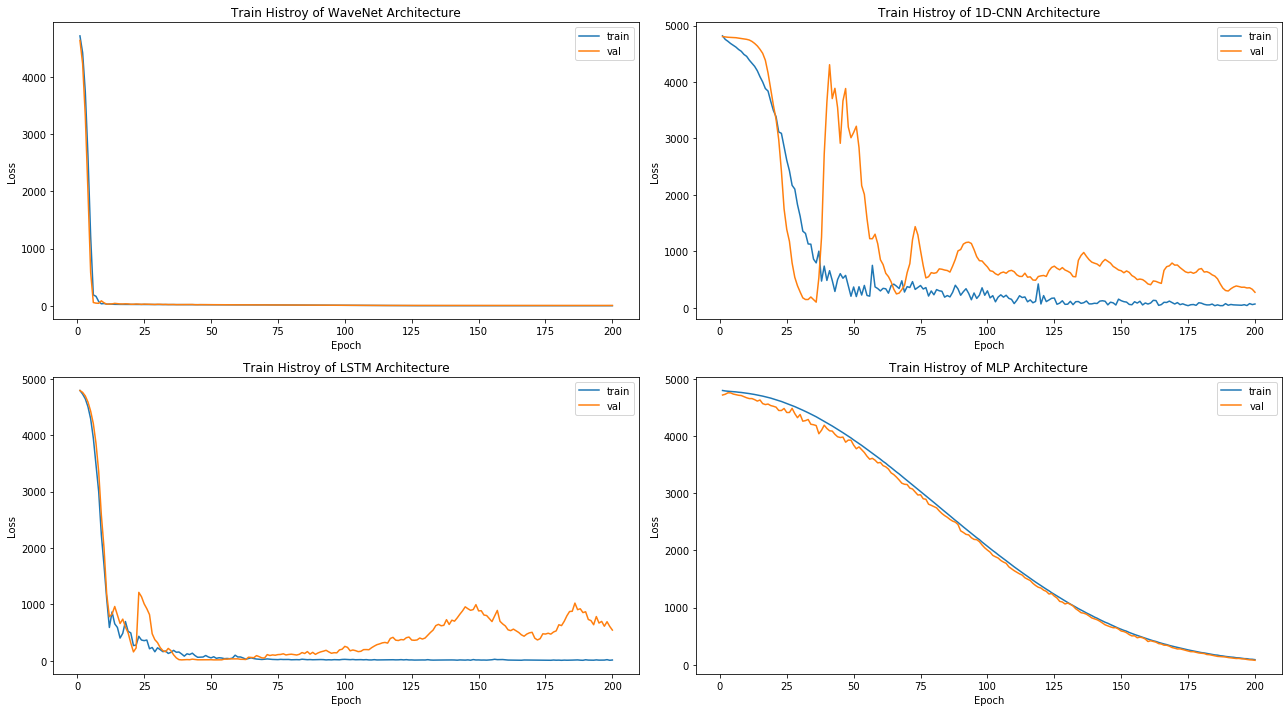

In [48]:
# plot training history for every model
fig, ax = plt.subplots(2, 2, figsize=(18,10))
plot_model_history(history_wavenet, ax = ax[0,0], plttitle='Train Histroy of WaveNet Architecture')
plot_model_history(history_cnn1D, ax = ax[0,1], plttitle='Train Histroy of 1D-CNN Architecture')
plot_model_history(history_lstm, ax = ax[1,0], plttitle='Train Histroy of LSTM Architecture')
plot_model_history(history_mlp, ax = ax[1,1], plttitle='Train Histroy of MLP Architecture')
plt.tight_layout()

### Evaluate performance of models

WaveNet Train Score: 1.32 MSE (1.15 RMSE)
WaveNet Test Score: 19.97 MSE (4.47 RMSE)
1D-CNN Train Score: 96.10 MSE (9.80 RMSE)
1D-CNN Test Score: 76.67 MSE (8.76 RMSE)
LSTM Train Score: 127.57 MSE (11.29 RMSE)
LSTM Test Score: 169.73 MSE (13.03 RMSE)
MLP Train Score: 85.28 MSE (9.23 RMSE)
MLP Test Score: 115.37 MSE (10.74 RMSE)


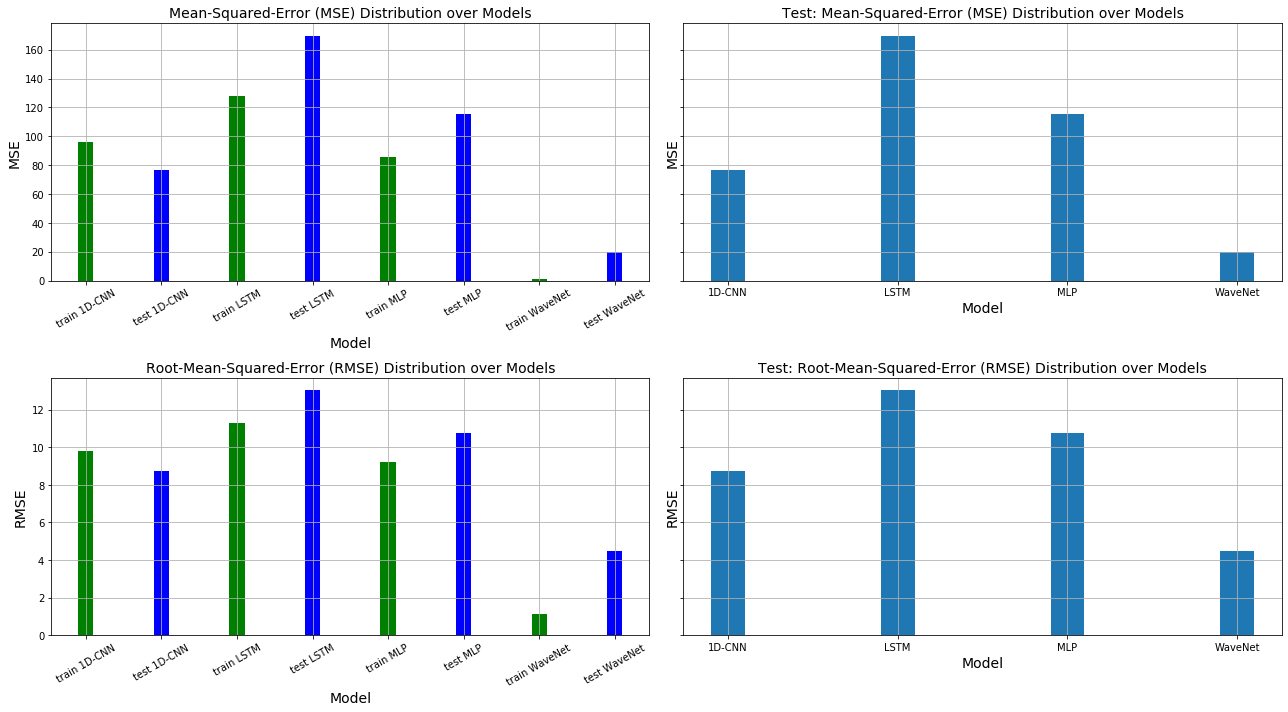

In [72]:
# WaveNet
trainScore_wavenet = wavenet.evaluate(X_train, y_train, verbose=0)
print('WaveNet Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_wavenet[0], math.sqrt(trainScore_wavenet[0])))
testScore_wavenet = wavenet.evaluate(X_test, y_test, verbose=0)
print('WaveNet Test Score: %.2f MSE (%.2f RMSE)' % (testScore_wavenet[0], math.sqrt(testScore_wavenet[0])))

# 1D-CNN
trainScore_cnn1D = cnn1D.evaluate(X_train, y_train, verbose=0)
print('1D-CNN Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_cnn1D[0], math.sqrt(trainScore_cnn1D[0])))
testScore_cnn1D = cnn1D.evaluate(X_test, y_test, verbose=0)
print('1D-CNN Test Score: %.2f MSE (%.2f RMSE)' % (testScore_cnn1D[0], math.sqrt(testScore_cnn1D[0])))

# LSTM
trainScore_lstm = lstm.evaluate(X_train, y_train, verbose=0)
print('LSTM Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_lstm[0], math.sqrt(trainScore_lstm[0])))
testScore_lstm = lstm.evaluate(X_test, y_test, verbose=0)
print('LSTM Test Score: %.2f MSE (%.2f RMSE)' % (testScore_lstm[0], math.sqrt(testScore_lstm[0])))

# MLP
trainScore_mlp = mlp.evaluate(X_train, y_train, verbose=0)
print('MLP Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_mlp[0], math.sqrt(trainScore_mlp[0])))
testScore_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print('MLP Test Score: %.2f MSE (%.2f RMSE)' % (testScore_mlp[0], math.sqrt(testScore_mlp[0])))

# Plot Errorbars (MSE & RMSE) for train and test
fig, ax = plt.subplots(2, 2, figsize=(18,10), sharey='row')

ax[0,0].bar([1,2,3,4,5,6,7,8], [trainScore_cnn1D[0], testScore_cnn1D[0], trainScore_lstm[0], testScore_lstm[0], trainScore_mlp[0], testScore_mlp[0], trainScore_wavenet[0], testScore_wavenet[0]], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[0,0].set_title('Mean-Squared-Error (MSE) Distribution over Models', fontsize=14)
ax[0,0].set_xlabel('Model', fontsize=14)
ax[0,0].set_ylabel('MSE', fontsize=14)
ax[0,0].set_xticks(np.arange(1,9))
ax[0,0].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30)
ax[0,0].grid()

ax[1,0].bar([1,2,3,4,5,6,7,8], [math.sqrt(trainScore_cnn1D[0]), math.sqrt(testScore_cnn1D[0]), math.sqrt(trainScore_lstm[0]), math.sqrt(testScore_lstm[0]), math.sqrt(trainScore_mlp[0]), math.sqrt(testScore_mlp[0]), math.sqrt(trainScore_wavenet[0]), math.sqrt(testScore_wavenet[0])], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[1,0].set_title('Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=14)
ax[1,0].set_xlabel('Model', fontsize=14)
ax[1,0].set_ylabel('RMSE', fontsize=14)
ax[1,0].set_xticks(np.arange(1,9))
ax[1,0].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30)
ax[1,0].grid()

ax[0,1].bar([1,2,3,4], [testScore_cnn1D[0], testScore_lstm[0], testScore_mlp[0], testScore_wavenet[0]], width=0.2)
ax[0,1].set_title('Test: Mean-Squared-Error (MSE) Distribution over Models', fontsize=14)
ax[0,1].set_xlabel('Model', fontsize=14)
ax[0,1].set_ylabel('MSE', fontsize=14)
ax[0,1].set_xticks(np.arange(1,5))
ax[0,1].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[0,1].grid()

ax[1,1].bar([1,2,3,4], [math.sqrt(testScore_cnn1D[0]), math.sqrt(testScore_lstm[0]), math.sqrt(testScore_mlp[0]), math.sqrt(testScore_wavenet[0])], width=0.2)
ax[1,1].set_title('Test: Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=14)
ax[1,1].set_xlabel('Model', fontsize=14)
ax[1,1].set_ylabel('RMSE', fontsize=14)
ax[1,1].set_xticks(np.arange(1,5))
ax[1,1].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[1,1].grid()

plt.tight_layout()

### Model prediction

In [50]:
# Select latest possible input data
X_predict = np.zeros((1, look_back, X_train.shape[2]))
X_predict[0] = feature_data[len(feature_data)-look_back:, :]

In [51]:
# WaveNet
trainPredict_wavenet = wavenet.predict(X_train)
testPredict_wavenet = wavenet.predict(X_test)
prediction_wavenet = wavenet.predict(X_predict)
print(f"WaveNet forecast for the next {horizon} months: {np.around(prediction_wavenet, 1)} (mio. tonnes CO2)")

# 1D-CNN
trainPredict_cnn1D = cnn1D.predict(X_train)
testPredict_cnn1D = cnn1D.predict(X_test)
prediction_cnn1D = cnn1D.predict(X_predict)
print(f"1D-CNN forecast for the next {horizon} months: {np.around(prediction_cnn1D, 1)} (mio. tonnes CO2)")

# LSTM
trainPredict_lstm = lstm.predict(X_train)
testPredict_lstm = lstm.predict(X_test)
prediction_lstm = lstm.predict(X_predict)
print(f"LSTM forecast for the next {horizon} months: {np.around(prediction_lstm, 1)} (mio. tonnes CO2)")

# MLP
trainPredict_mlp = mlp.predict(X_train)
testPredict_mlp = mlp.predict(X_test)
prediction_mlp = mlp.predict(X_predict)
print(f"MLP forecast for the next {horizon} months: {np.around(prediction_mlp, 1)} (mio. tonnes CO2)")

WaveNet forecast for the next 6 months: [[76.1 76.4 78.7 77.2 76.  73.9]] (mio. tonnes CO2)
1D-CNN forecast for the next 6 months: [[0.4 0.4 0.4 0.5 0.5 0.5]] (mio. tonnes CO2)
LSTM forecast for the next 6 months: [[52.8 55.2 51.2 48.7 51.2 46.3]] (mio. tonnes CO2)
MLP forecast for the next 6 months: [[-7.8408755e+08 -6.9839750e+08 -7.6182317e+08 -4.2227206e+08
  -3.5718426e+08  8.1273344e+07]] (mio. tonnes CO2)


In [52]:
# Shift predictions accordingly for plotting purposes

train_pad = np.zeros(look_back)
train_pad[:] = np.NaN
test_pad = np.zeros(train_size+look_back)
test_pad[:] = np.NaN
pred_pad = np.zeros(len(feature_data))
pred_pad[:] = np.NaN

# WaveNet
trainPredict_wavenet = np.concatenate((train_pad, trainPredict_wavenet[:,0]))
testPredict_wavenet = np.concatenate((test_pad, testPredict_wavenet[:,0]))
prediction_wavenet = np.concatenate((pred_pad, prediction_wavenet.reshape(-1)))

# 1D-CNN
trainPredict_cnn1D = np.concatenate((train_pad, trainPredict_cnn1D[:,0]))
testPredict_cnn1D = np.concatenate((test_pad, testPredict_cnn1D[:,0]))
prediction_cnn1D = np.concatenate((pred_pad, prediction_cnn1D.reshape(-1)))

# LSTM
trainPredict_lstm = np.concatenate((train_pad, trainPredict_lstm[:,0]))
testPredict_lstm = np.concatenate((test_pad, testPredict_lstm[:,0]))
prediction_lstm = np.concatenate((pred_pad, prediction_lstm.reshape(-1)))

# MLP
trainPredict_mlp = np.concatenate((train_pad, trainPredict_mlp[:,0]))
testPredict_mlp = np.concatenate((test_pad, testPredict_mlp[:,0]))
prediction_mlp = np.concatenate((pred_pad, prediction_mlp.reshape(-1)))

### Plot results

In [53]:
# Create time scope (x-axis) for final plot

time_scope = []
for i in np.arange(int(first_date.split('/')[1]), int(last_date.split('/')[1])+1):
    for j in np.arange(1,13):
        time_scope.append(str(j)+"/"+str(i))

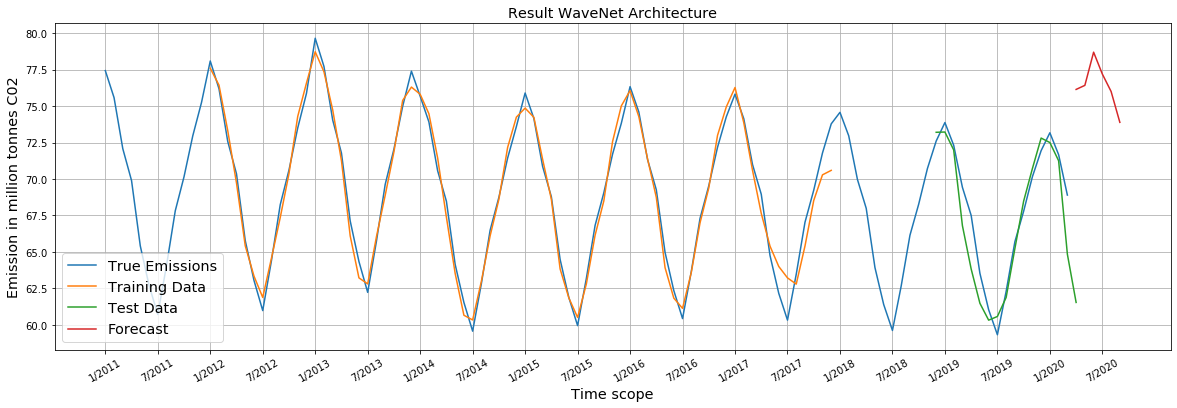

In [54]:
# WaveNet resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_wavenet, label='Training Data')
plt.plot(testPredict_wavenet, label='Test Data')
plt.plot(prediction_wavenet, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30)
plt.xlabel("Time scope", fontsize='x-large')
plt.ylabel("Emission in million tonnes C02", fontsize='x-large')
plt.title('Result WaveNet Architecture', fontsize='x-large')
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

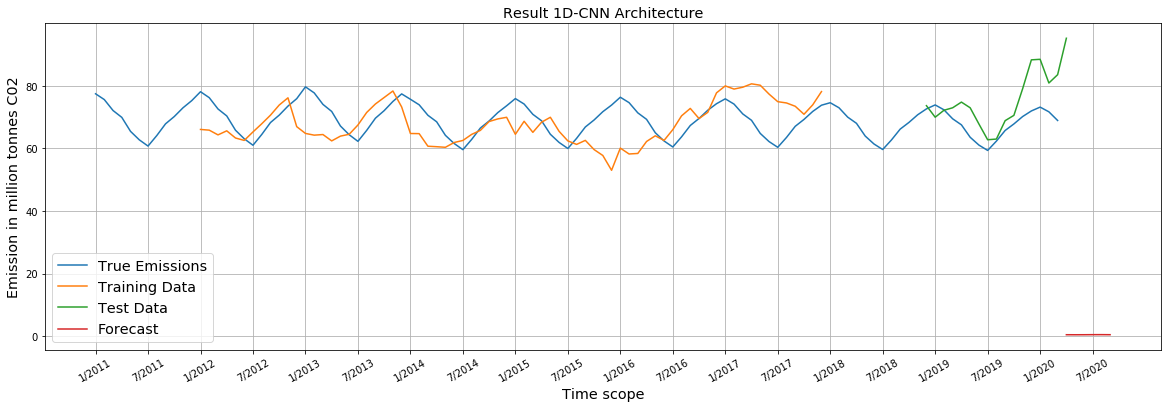

In [55]:
# 1D-CNN resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_cnn1D, label='Training Data')
plt.plot(testPredict_cnn1D, label='Test Data')
plt.plot(prediction_cnn1D, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30)
plt.xlabel("Time scope", fontsize='x-large')
plt.ylabel("Emission in million tonnes C02", fontsize='x-large')
plt.title('Result 1D-CNN Architecture', fontsize='x-large')
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

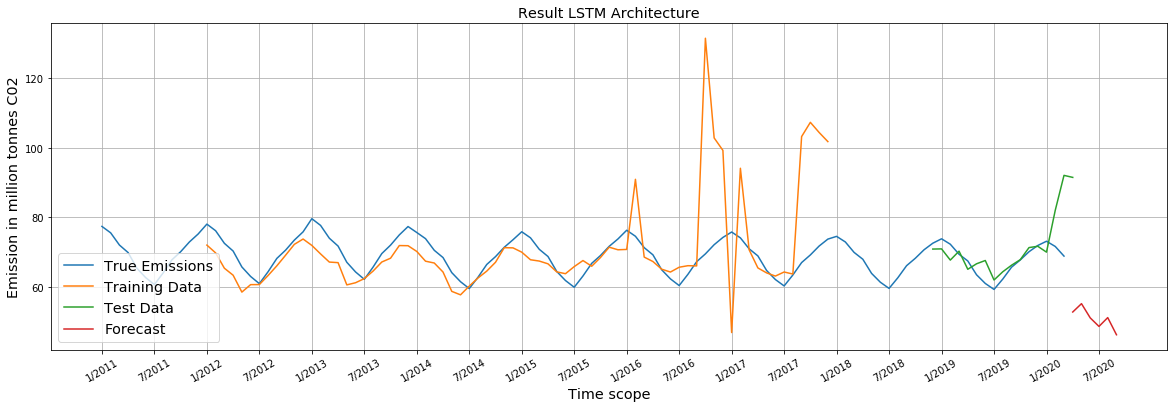

In [56]:
# LSTM resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_lstm, label='Training Data')
plt.plot(testPredict_lstm, label='Test Data')
plt.plot(prediction_lstm, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30)
plt.xlabel("Time scope", fontsize='x-large')
plt.ylabel("Emission in million tonnes C02", fontsize='x-large')
plt.title('Result LSTM Architecture', fontsize='x-large')
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

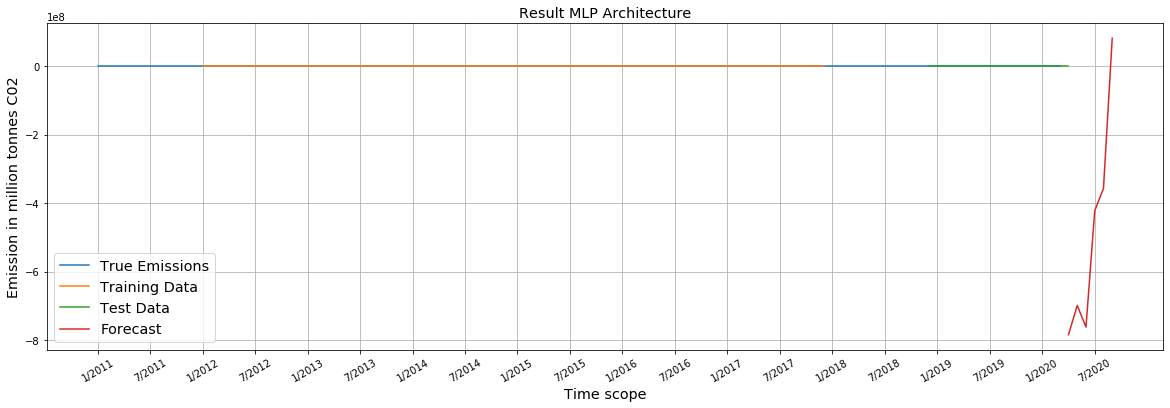

In [57]:
# MLP resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_mlp, label='Training Data')
plt.plot(testPredict_mlp, label='Test Data')
plt.plot(prediction_mlp, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30)
plt.xlabel("Time scope", fontsize='x-large')
plt.ylabel("Emission in million tonnes C02", fontsize='x-large')
plt.title('Result MLP Architecture', fontsize='x-large')
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()